In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import keras_tuner as kt
import shap

# Load data
df = pd.read_csv('C:\\Users\\vidhi\\Downloads\\vscode\\aq\\processed_data.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5478 entries, 0 to 5477
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamp            5478 non-null   object 
 1   PM2.5 (µg/m³)        5349 non-null   float64
 2   PM10 (µg/m³)         5348 non-null   float64
 3   NO (µg/m³)           5350 non-null   float64
 4   NO2 (µg/m³)          5347 non-null   float64
 5   NOx (ppb)            5351 non-null   float64
 6   NH3 (µg/m³)          5268 non-null   float64
 7   SO2 (µg/m³)          5290 non-null   float64
 8   CO (mg/m³)           5320 non-null   float64
 9   Ozone (µg/m³)        5164 non-null   float64
 10  Benzene (µg/m³)      5063 non-null   float64
 11  Toluene (µg/m³)      5062 non-null   float64
 12  Xylene (µg/m³)       5058 non-null   float64
 13  O Xylene (µg/m³)     0 non-null      float64
 14  Eth-Benzene (µg/m³)  0 non-null      float64
 15  MP-Xylene (µg/m³)    8 non-null      f

In [3]:
# Convert 'timestamp' to datetime and extract useful time-based features
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')

df['hour'] = df['Timestamp'].dt.hour
df['day_of_week'] = df['Timestamp'].dt.dayofweek
df['month'] = df['Timestamp'].dt.month
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Sorting by timestamp to maintain chronological order
df = df.sort_values('Timestamp')
df.ffill(inplace=True)  # Forward fill missing values
df.bfill(inplace=True)  # Backward fill missing values


# Selecting relevant columns (features and AQI columns)
features = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO2 (µg/m³)','Ozone (µg/m³)', 'SO2 (µg/m³)']  # Include additional temporal features
target = 'Overall_AQI'  # You can change this to predict other AQI values

# Data normalization/scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])


In [4]:

# Sequence creation
def create_sequences(data, time_steps=24):
    sequences = []
    labels = []
    for i in range(len(data) - time_steps):
        seq = data[i:i+time_steps]
        label = data[i + time_steps][-1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)
   

time_steps = 24  # 24-hour window
X, y = create_sequences(scaled_data, time_steps)

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)




In [5]:
time_steps = 24
X, y = create_sequences(scaled_data, time_steps)
from tensorflow.keras.optimizers import Adam
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=256, step=32), 
                                 return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Bidirectional(LSTM(units=hp.Int('units_2', min_value=32, max_value=256, step=32))))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mse')
    return model

# Initialize the tuner
tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=5, executions_per_trial=3)

# Perform the search
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Train the Bi-LSTM model
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with the best hyperparameters
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Get features from the LSTM model
train_features = model.predict(X_train)
test_features = model.predict(X_test)
train_features = train_features.reshape(train_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)



Trial 5 Complete [00h 18m 36s]
val_loss: 0.010217087964216868

Best val_loss So Far: 0.009525932061175505
Total elapsed time: 01h 28m 27s
Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 2.1403 - val_loss: 0.0739
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0654 - val_loss: 0.0526
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0525 - val_loss: 0.0469
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0443 - val_loss: 0.0392
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0391 - val_loss: 0.0354
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0339 - val_loss: 0.0321
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0293 - val_loss: 0.0356
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0298 - val_loss: 0.0253
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0249 - val_loss: 0.0242
Epoch 10/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0243 

MSE after tuning: 0.006621550916346294
R-squared (R²): 0.7116203817850368


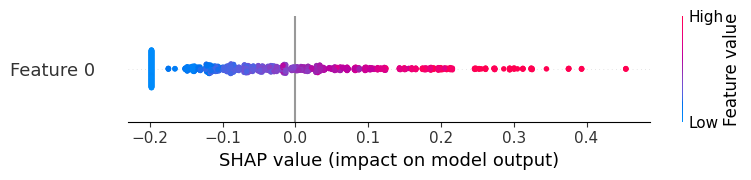

In [13]:
import xgboost as xgb
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(train_features, y_train)

# Make predictions
y_pred = xgb_model.predict(test_features)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
print(f'MSE after tuning: {mse}')



y_test_rescaled = scaler.inverse_transform(np.c_[np.zeros((y_test.shape[0], len(features))), y_test])[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.c_[np.zeros((y_pred.shape[0], len(features))), y_pred])[:, -1]



r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"R-squared (R²): {r2}")

# SHAP analysis for feature importance
explainer = shap.Explainer(xgb_model, train_features)  # Use train_features
shap_values = explainer(test_features)
shap.summary_plot(shap_values, test_features)


In [14]:
r2 = r2_score(y_test_rescaled,y_pred_rescaled)
print(f"R-squared (R²): {r2}")


R-squared (R²): 0.7116203817850368


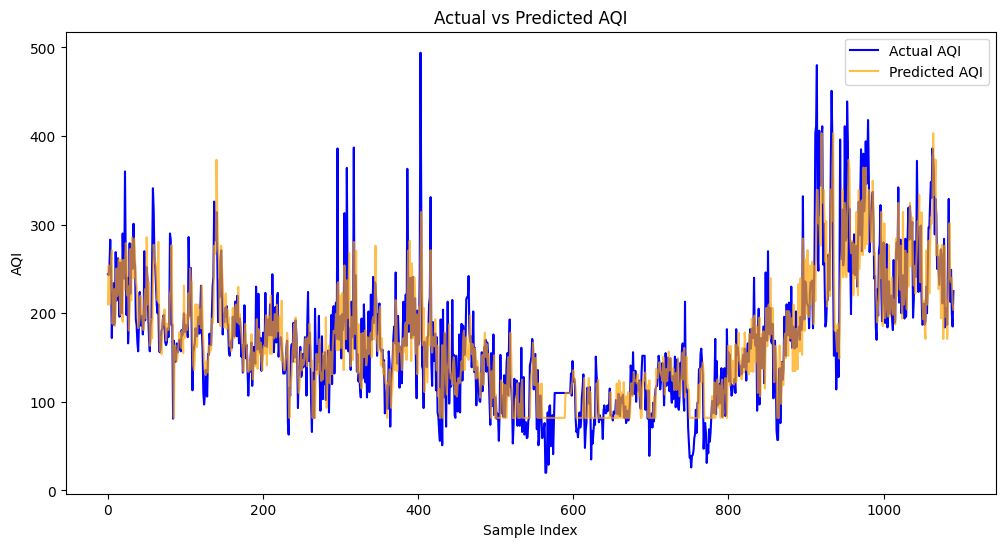

In [15]:
# Plot actual vs predicted
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual AQI', color='blue')
plt.plot(y_pred_rescaled, label='Predicted AQI', color='orange', alpha=0.7)
plt.title('Actual vs Predicted AQI')
plt.xlabel('Sample Index')
plt.ylabel('AQI')
plt.legend()
plt.show()

In [18]:
import joblib
scaler_file = 'scaler.pkl'
joblib.dump(scaler, scaler_file)
print(f"Scaler saved to {scaler_file}")

# Save the models
model.save('bilstm_model.keras')
xgb_model.save_model('xgb_model.json')

print(f"Scaler saved to {scaler_file}, Bi-LSTM model saved to {model}, XGBoost model saved to {xgb_model}")

Scaler saved to scaler.pkl
Scaler saved to scaler.pkl, Bi-LSTM model saved to <Sequential name=sequential_1, built=True>, XGBoost model saved to XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100

print(f"R-squared (R²): {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

R-squared (R²): 0.7116203817850368
RMSE: 40.116845946148985
MAE: 29.431950269722808
MAPE: 20.82725876693649%
